# **Grover Algorithm Implementation**
## Looping for automatic data output 
## OR 
## Manualy step through the code
## OR 
## 'Run All' and get both



## [Looped Running](#looped_running)
This version of the code loops through the target values and exports data values (target probabilities and timings) to a csv file for further processing. It creates each cicuit (2,3,4 and 5-qubits) once and then runs each against the QASM Simulator and then against an IBM Quantum device.

To run the looped code, you will need to scroll down to the cell which says, ['**Run the code from the 2 cells below**'](#looped_running) and run the two cells, **making sure that the preceding cells have also run**, so that the program has the functions and variables available to do it.

# <font color=red> **Important Information for running on the IBM machines** </font>
### In order to keep personal / secure information separate from the Python program, rather than hard-code the quantum server key directly into the Python code, it is stored in the local file called *ibm_token.txt* supplied with this notebook. This file should be placed in the same directory as the notebook, and the code will run against the quantum server.
### <font color=red> **My IBM key is in the file supplied with this notebook - make sure that this is in place before running** </font>

## [Manual Running](#manual_running)
Useful for circuit development and examination
If you do **not** wish to run the looped code, scroll down to go directly to the **Manual Running** section 
(i.e. the code without the loop and data output - code that creates the individual components of the circuit separately - cells can be run individually) 



# **Run All**
With the ibm_token.txt file in place (see above) it is possible simply to 'Run all' but please note that the Loop-based part of the code will submit circuits to the IBM server 4 times. This is often **not** a problem, but at times of high demand (or if someone has submitted a long-running or stalled process), there can be delays. 
### It will also output 2 result files.

# **Notebook Structure**

### Needed for Looped and Manual Runs:
    Install Qiskit

    Initialise: Import required libraries

    Define functions for the circuit creation

   **Note: Code from the IBM documentation pages has been used unchanged for the recursive
           Multi-Control Toffoli operation and for connecting to the IBM servers.**

### Looped Running section – 4x loop for 2, 3, 4 and 5 qubit targets:

        Cell 1: Set up output file names

        Cell 2: 
                Loop through targets
                Set up appropriate circuits
                Run against Simulator
                Submit to Quantum server


### [Manual Running](#manual_running):
        Step through cells in order setting the target, 
        Select Oracle to create for target
        Create amplification for target
        Run against Simulator
        Select Quantum server and submit


In [26]:
# This will install quiskit if required (if not required, it will just give
# 'Requirement already satisfied messages). However, if you have have a version
# already installed locally and you don't want it to update if updates have been
# issued, it is ok to comment it out.
# This is needed with any new colab session.

!pip install qiskit

In [27]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np
import math
import time
import csv
# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

In [28]:
import warnings
warnings.filterwarnings('ignore')   # Suppress pink box warnings for clear output
pi = math.pi

In [29]:
# Set uo the initial superposition with Hadamards

def init_circuit():
    #Start with Hadamards
    qc.h(qr)
    #qc.draw(output="mpl",scale=0.4)

In [30]:
# Note: Code from this cell is taken directly from the documentation at
# https://qiskit.org/documentation/_modules/qiskit/aqua/circuits/gates/multi_control_toffoli_gate.html

# It is supplied as part of the documentation 


def _mct_v_chain(qc, control_qubits, target_qubit, ancillary_qubits, dirty_ancilla=False):
    """
    Create new MCT circuit by chaining Toffoli gates into a V shape.

    The dirty_ancilla mode is from https://arxiv.org/abs/quant-ph/9503016 Lemma 7.2

    All intermediate Toffoli gates are implemented up to a relative phase,
    see https://arxiv.org/abs/1508.03273

    An additional saving of 4 CNOTs is achieved
    by using the Toffoli implementation from Section IV.B of https://arxiv.org/abs/1508.03273
    """

    if len(ancillary_qubits) < len(control_qubits) - 2:
        raise AquaError('Insufficient number of ancillary qubits.')

    if dirty_ancilla:
        anci_idx = len(control_qubits) - 3

        qc.u2(0, pi, target_qubit)
        qc.cx(target_qubit, ancillary_qubits[anci_idx])
        qc.u1(-pi/4, ancillary_qubits[anci_idx])
        qc.cx(control_qubits[len(control_qubits) - 1], ancillary_qubits[anci_idx])
        qc.u1(pi/4, ancillary_qubits[anci_idx])
        qc.cx(target_qubit, ancillary_qubits[anci_idx])
        qc.u1(-pi/4, ancillary_qubits[anci_idx])
        qc.cx(control_qubits[len(control_qubits) - 1], ancillary_qubits[anci_idx])
        qc.u1(pi/4, ancillary_qubits[anci_idx])

        for idx in reversed(range(2, len(control_qubits) - 1)):
            qc.rccx(control_qubits[idx], ancillary_qubits[anci_idx - 1], ancillary_qubits[anci_idx])
            anci_idx -= 1

    anci_idx = 0
    qc.rccx(control_qubits[0], control_qubits[1], ancillary_qubits[anci_idx])
    for idx in range(2, len(control_qubits) - 1):
        qc.rccx(control_qubits[idx], ancillary_qubits[anci_idx], ancillary_qubits[anci_idx + 1])
        anci_idx += 1

    if dirty_ancilla:
        qc.u1(-pi/4, ancillary_qubits[anci_idx])
        qc.cx(control_qubits[len(control_qubits) - 1], ancillary_qubits[anci_idx])
        qc.u1(pi/4, ancillary_qubits[anci_idx])
        qc.cx(target_qubit, ancillary_qubits[anci_idx])
        qc.u1(-pi/4, ancillary_qubits[anci_idx])
        qc.cx(control_qubits[len(control_qubits) - 1], ancillary_qubits[anci_idx])
        qc.u1(pi/4, ancillary_qubits[anci_idx])
        qc.cx(target_qubit, ancillary_qubits[anci_idx])
        qc.u2(0, pi, target_qubit)
    else:
        qc.ccx(control_qubits[len(control_qubits) - 1], ancillary_qubits[anci_idx], target_qubit)

    for idx in reversed(range(2, len(control_qubits) - 1)):
        qc.rccx(control_qubits[idx], ancillary_qubits[anci_idx - 1], ancillary_qubits[anci_idx])
        anci_idx -= 1
    qc.rccx(control_qubits[0], control_qubits[1], ancillary_qubits[anci_idx])

    if dirty_ancilla:
        anci_idx = 0
        for idx in range(2, len(control_qubits) - 1):
            qc.rccx(control_qubits[idx], ancillary_qubits[anci_idx], ancillary_qubits[anci_idx + 1])
            anci_idx += 1


def _cccx(qc, qrs, angle=pi / 4):
    """
    A 3-qubit controlled-NOT.

    Implementation based on Page 17 of Barenco et al.

    Args:
        qc (QuantumCircuit): quantum circuit
        qrs (list[QuantumRegister]): The last qubit is the target, the rest are controls

        angle (float): default pi/4 when x is the NOT gate, set to pi/8 for square root of NOT
    """
    assert len(qrs) == 4, "There must be exactly 4 qubits of quantum registers for cccx"

    # controlled-V
    qc.h(qrs[3])
    qc.cu1(-angle, qrs[0], qrs[3])
    qc.h(qrs[3])
    # ------------

    qc.cx(qrs[0], qrs[1])

    # controlled-Vdag
    qc.h(qrs[3])
    qc.cu1(angle, qrs[1], qrs[3])
    qc.h(qrs[3])
    # ---------------

    qc.cx(qrs[0], qrs[1])

    # controlled-V
    qc.h(qrs[3])
    qc.cu1(-angle, qrs[1], qrs[3])
    qc.h(qrs[3])
    # ------------

    qc.cx(qrs[1], qrs[2])

    # controlled-Vdag
    qc.h(qrs[3])
    qc.cu1(angle, qrs[2], qrs[3])
    qc.h(qrs[3])
    # ---------------

    qc.cx(qrs[0], qrs[2])

    # controlled-V
    qc.h(qrs[3])
    qc.cu1(-angle, qrs[2], qrs[3])
    qc.h(qrs[3])
    # ------------

    qc.cx(qrs[1], qrs[2])

    # controlled-Vdag
    qc.h(qrs[3])
    qc.cu1(angle, qrs[2], qrs[3])
    qc.h(qrs[3])
    # ---------------

    qc.cx(qrs[0], qrs[2])

    # controlled-V
    qc.h(qrs[3])
    qc.cu1(-angle, qrs[2], qrs[3])
    qc.h(qrs[3])


def _ccccx(qc, qrs):
    """
    a 4-qubit controlled-NOT.

    An implementation based on Page 21 (Lemma 7.5) of Barenco et al.

    Args:
        qc (QuantumCircuit): quantum circuit
        qrs (list[QuantumRegister]): The last qubit is the target, the rest are controls
    """
    assert len(qrs) == 5, "There must be exactly 5 qubits for ccccx"

    # controlled-V
    qc.h(qrs[4])
    qc.cu1(-pi / 2, qrs[3], qrs[4])
    qc.h(qrs[4])
    # ------------

    _cccx(qc, qrs[:4])

    # controlled-Vdag
    qc.h(qrs[4])
    qc.cu1(pi / 2, qrs[3], qrs[4])
    qc.h(qrs[4])
    # ------------

    _cccx(qc, qrs[:4])
    _cccx(qc, [qrs[0], qrs[1], qrs[2], qrs[4]], angle=pi / 8)


def _multicx(qc, qrs, qancilla=None):
    """
    Construct a circuit for multi-qubit controlled not

    Args:
        qc (QuantumCircuit): quantum circuit
        qrs (list[QuantumRegister]): list of quantum registers of at least length 1
        qancilla (QuantumRegister): a quantum register. can be None if len(qrs) <= 5

    Returns:
        qc: a circuit appended with multi-qubit cnot
    """
    #print(len(qrs))
    #print(len(qc))
    #print(qc)
    #print(qr)
    if not qrs:
        pass
    elif len(qrs) == 1:
        qc.x(qrs[0])
    elif len(qrs) == 2:
        qc.cx(qrs[0], qrs[1])
    elif len(qrs) == 3:
        qc.ccx(qrs[0], qrs[1], qrs[2])
    else:
        _multicx_recursion(qc, qrs, qancilla)


def _multicx_recursion(qc, qrs, qancilla=None):
    if len(qrs) == 4:
        print('_cccx')
        _cccx(qc, qrs)
    elif len(qrs) == 5:
        _ccccx(qc, qrs)
    else:  # qrs[0], qrs[n-2] is the controls, qrs[n-1] is the target, and qancilla as working qubit
        assert qancilla is not None, \
            "There must be an ancilla qubit not necessarily initialized to zero"
        n = len(qrs)
        m1 = ceil(n / 2)
        _multicx_recursion(qc, [*qrs[:m1], qancilla], qrs[m1])
        _multicx_recursion(qc, [*qrs[m1:n - 1], qancilla, qrs[n - 1]], qrs[m1 - 1])
        _multicx_recursion(qc, [*qrs[:m1], qancilla], qrs[m1])
        _multicx_recursion(qc, [*qrs[m1:n - 1], qancilla, qrs[n - 1]], qrs[m1 - 1])

#QuantumCircuit.mct = mct

In [31]:
#The different oracles required for the different Grover algorithm circuits

def oracle_11001():   #10010
   
    ctrl_qubs = [qr[0],qr[1],qr[2],qr[3]]
    trgt_qub  =  qr[4]

    qc.x(qr[1])
    qc.x(qr[2])


    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate
    qc.h(qr[4])

    #_multicx(ctrl_qubs,trgt_qub,None, mode='Advanced')
    #_multicx(ctrl_qubs,trgt_qub,None)

    qc.mct(ctrl_qubs,trgt_qub,None, mode='advanced')
    #_multicx(qs,qr)
    qc.h(qr[4])
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate
    
    qc.x(qr[1])
    qc.x(qr[2])

 
    qc.barrier(qr)

def oracle_1011():   #10010
   
    ctrl_qubs = [qr[0],qr[1],qr[2]]
    trgt_qub  =  qr[3]

    qc.x(qr[2])


    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate
    qc.h(qr[3])

    #_multicx(ctrl_qubs,trgt_qub,None, mode='Advanced')
    #_multicx(ctrl_qubs,trgt_qub,None)

    qc.mct(ctrl_qubs,trgt_qub,None, mode='advanced')
    #_multicx(qs,qr)
    qc.h(qr[3])
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate
    
    qc.x(qr[2])

 
    qc.barrier(qr)

def oracle_110():   #10010
   
    ctrl_qubs = [qr[0],qr[1]]
    trgt_qub  =  qr[2]

    qc.x(qr[0])


    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate
    qc.h(qr[2])

    #_multicx(ctrl_qubs,trgt_qub,None, mode='Advanced')
    #_multicx(ctrl_qubs,trgt_qub,None)

    qc.mct(ctrl_qubs,trgt_qub,None, mode='advanced')
    #_multicx(qs,qr)
    qc.h(qr[2])
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate
    
    qc.x(qr[0])

 
    qc.barrier(qr)

def oracle_10():   #10010
   
    ctrl_qubs = [qr[0]]
    trgt_qub  =  qr[1]

    qc.x(qr[0])


    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate
    qc.h(qr[1])

    #_multicx(ctrl_qubs,trgt_qub,None, mode='Advanced')
    #_multicx(ctrl_qubs,trgt_qub,None)

    qc.mct(ctrl_qubs,trgt_qub,None, mode='advanced')
    #_multicx(qs,qr)
    qc.h(qr[1])
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate
    
    qc.x(qr[0])

 
    qc.barrier(qr)

########################################################################

# The different amplitude amplifications for different circuits 
# (2, 3, 4 and 5 qubit circuits)

def amplify_3():
    ctrl_qubs = [qr[0],qr[1]]
    trgt_qub  =  qr[2]

    qc.h(qr)
    qc.x(qr)
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate

    qc.h(qr[2])
    #_multicx(qc, qr)
    qc.mct(ctrl_qubs,trgt_qub,None, mode='advanced')
    qc.h(qr[2])
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate

    qc.x(qr)
    qc.h(qr)
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate

def amplify_2():
    ctrl_qubs = [qr[0]]
    trgt_qub  =  qr[1]

    qc.h(qr)
    qc.x(qr)
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate

    qc.h(qr[1])
    #_multicx(qc, qr)
    qc.mct(ctrl_qubs,trgt_qub,None, mode='advanced')
    qc.h(qr[1])
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate

    qc.x(qr)
    qc.h(qr)
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate


def amplify_4():

    ctrl_qubs = [qr[0],qr[1],qr[2]]
    trgt_qub  = qr[3]

    qc.h(qr)
    qc.x(qr)
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate

    qc.h(qr[3])
    #_multicx(qc, qr)
    qc.mct(ctrl_qubs,trgt_qub,None, mode='advanced')
    qc.h(qr[3])
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate

    qc.x(qr)
    qc.h(qr)
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate



def amplify_5():

    ctrl_qubs = [qr[0],qr[1],qr[2],qr[3]]
    trgt_qub  =  qr[4]

    qc.h(qr)
    qc.x(qr)
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate

    qc.h(qr[4])
    #_multicx(qc, qr)
    qc.mct(ctrl_qubs,trgt_qub,None, mode='advanced')
    qc.h(qr[4])
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate

    qc.x(qr)
    qc.h(qr)
    qc.barrier(qr)   # Functional barrier - prevent misalignmnet of subsequent gate

In [32]:
#Code to select which circuit to set up

def select_circuit():
  
  if num_qubits == 2:
    oracle_10()
    amplify_2()
    return
  if num_qubits == 3:
    oracle_110()
    amplify_3()
    return
  if num_qubits == 4:
    oracle_1011()
    amplify_4()
    return
  if num_qubits == 5:
    oracle_11001()
    amplify_5()
    return
  else:
    print('Too many qubits required')


In [33]:
# Code to run the circuit against the simulator

def run_sim():
  backend_sim = Aer.get_backend('statevector_simulator')
  job_sim = execute(qc, backend_sim)
  statevec = job_sim.result().get_statevector()
  print(statevec)

  backend = BasicAer.get_backend('qasm_simulator')
  shots = 8192
  timeBefore_sim = time.clock()
  results = execute(qc, backend=backend, shots=shots).result()
  timeAfter_sim = time.clock()
  answer = results.get_counts()
  plot_histogram(answer)

  #Manual Timing
  elapsed_time_sim = timeAfter_sim - timeBefore_sim
  #print(elapsed_time_sim)
  
  #Percentage Value for target
  target_percent = answer[target]/sum(answer.values())
  print(target_percent)

  sim_backend = backend
  sim_target_percent = target_percent
  sim_time_taken = results.time_taken

  #Write results to file
  with open(sim_result_file, 'a', newline='') as sim_csvfile:
    sim_result_write = csv.writer(sim_csvfile)
    sim_result_write.writerow([num_qubits,target,sim_backend,sim_target_percent,sim_time_taken,elapsed_time_sim])



In [34]:
# Code to run the circuit against the IBM quantum machine

def run_quant():
  from qiskit import IBMQ
  f = open('ibm_token.txt')

  ibm_key = f.readline()
  f.close()
  IBMQ.save_account(ibm_key )

  IBMQ.load_account()
  IBMQ.providers()

  provider = IBMQ.get_provider("ibm-q")

  selected_ibm_server = "ibmq_burlington"
  shots =8192
  #backend = provider.get_backend("ibmq_london")
  backend = provider.get_backend(selected_ibm_server)

  optimization = 1

  from qiskit.tools.monitor import job_monitor
  timeBefore_aer = time.clock()

  job = execute(qc, backend=backend, shots=8192, max_credits=10,optimization_level=optimization)
  timeAfter_aer = time.clock()

  job_monitor(job, interval = 2)

  results = job.result()
  answer = results.get_counts(qc)
  plot_histogram(answer)

  #Manual Timing
  elapsed_time_aer = timeAfter_aer - timeBefore_aer
  print(elapsed_time_aer)

  #Percentage Value for target
  target_percent = answer[target]/sum(answer.values())
  print(target_percent)

  with open(quant_result_file, 'a', newline='') as quant_csvfile:
    quant_result_write = csv.writer(quant_csvfile)
    quant_result_write.writerow([num_qubits,target,backend,optimization,target_percent,results.time_taken,elapsed_time_aer])



<a id='looped_running'></a>
# Looped running
### **Important:** **All of the cells above** need to have been run for the functions and variables to be recognised by the code in the first two cells below.

## Run the code from the 2 cells below

In [35]:
# Code to create an output file to save the results to
# Two files are created - one for the simulator resulys and one for the
# quantum device. The file names are appended with a pseudo-random set of
# numbers based on the time in order to prevent overwriting of results


now = str(int(time.time())) +'.csv'
sim_result_file = 'sim_results_'+ now
quant_result_file = 'quant_results_'+ now

  #sim_result_file = 'sim_results.csv'
  #quant_result_file = 'quant_results.csv'


with open(sim_result_file, 'w', newline='') as sim_csvfile:
  #fieldnames = ['SimNumQubits','SimTarget','Simulator','ProbSim','SimTime','SimManualTime','QuantQubits','Machine','Optimizer', 'QuantProb','QuantTime','QuantManualTime' ]
  ###result_write = csv.writer(csvfile)
  ###result_write.writerow(['SimNumQubits','SimTarget','Simulator','ProbSim','SimTime','SimManualTime','QuantQubits','Machine','Optimizer', 'QuantProb','QuantTime','QuantManualTime'])
  sim_result_write = csv.writer(sim_csvfile)
  sim_result_write.writerow(['SimNumQubits','SimTarget','Simulator','ProbSim','SimTime','SimManualTime'])

with open(quant_result_file, 'w', newline='') as quant_csvfile:
  quant_result_write = csv.writer(quant_csvfile)
  quant_result_write.writerow(['QuantQubits','Target','Machine','Optimizer', 'QuantProb','QuantTime','QuantManualTime'])

#result_write({'SimNumQubits': 'NumQubits','SimTarget': 'Target','Simulator': 'Simulator','ProbSim':'Simulator Probability','SimTime': 'Time Taken','SimManualTime':'Manual Tine','QuantQubits':'Num Qubits','Machine': 'Machine','Optimizer':'Optimization Level', 'QuantProb':'Machine Probability','QuantTime':'Time Taken','QuantManualTime':'Manual Time'})
#print(result_file)

2 10 2
[ 0.+0.0000000e+00j  0.+0.0000000e+00j -1.+5.5109106e-16j
  0.+0.0000000e+00j]
1.0


Credentials already present. Set overwrite=True to overwrite.
Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
3.8239618000006885
0.509765625
6 110 3
[0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 1.-1.29144572e-15j 0.+0.00000000e+00j]


Credentials already present. Set overwrite=True to overwrite.


0.9512939453125


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
4.851623599999584
0.2364501953125
11 1011 4
[ 0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j  0.+0.00000000e+00j -1.+8.87231608e-15j
  0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j]


Credentials already present. Set overwrite=True to overwrite.


0.962158203125


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
4.867483300000458
0.0611572265625
25 11001 5
[0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 1.-2.76170742e-14j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
 0.+0.00000000e+00j 0.+0.00000000e+00j]


Credentials already present. Set overwrite=True to overwrite.


0.9993896484375


Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
7.262332600001173
0.0181884765625


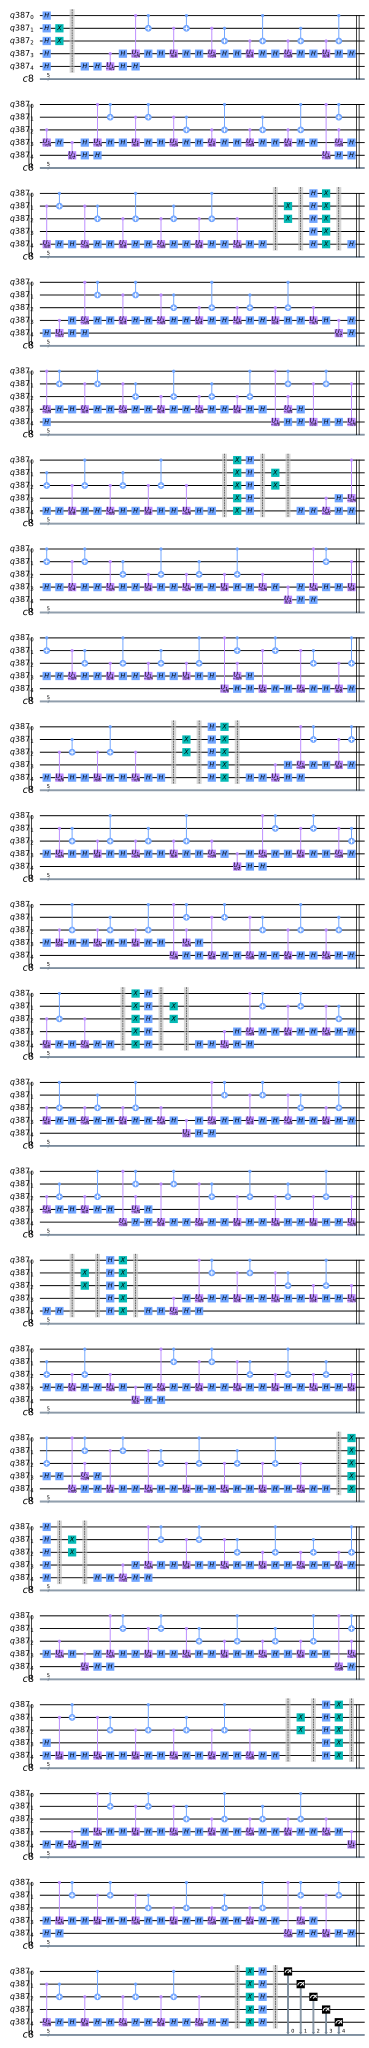

In [36]:
# Running the circuit
# The text output of the cell is more of a guide to the progress of the process
# rather than of any use, though it does print out the final circuit.

# Put numbers from autobiography in ascending order of bits 2 - 5

biog = []
biog=[2,6,11,25]
for i in range(len(biog)):
  value = biog[i]
  target = bin(value)[2:]
  print(value, target, len(target))
  num_qubits=len(target)

  grover_iteration = int((pi/4)*math.sqrt(2**num_qubits))

  qr = QuantumRegister(num_qubits)
  cr = ClassicalRegister(num_qubits)

  qc = QuantumCircuit(qr,cr)
  init_circuit()
  for i in range(grover_iteration):   
    select_circuit()

  qc.measure(qr, cr)

  run_sim()
  run_quant()

  qc.draw(output="mpl",scale=0.4)
qc.draw(output="mpl",scale=0.4)

<a id='manual_running'></a>
# **Manual Running**

## To build the circuit in individual stages - initialisation, then oracle, then amplification, with visualisations of each, run the cells below individually.
### **Note:** You will need to run from the top of the notebook down to (but not including) the 'Run with Loop' cells
### This is to import the required libraries and set up the necessary functions and variables.

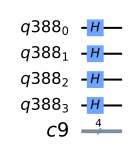

In [37]:
# MANUAL Running the circuit

# Used for development and visualising the circuits
# Select oracle and run each component manually 
# Then manually run the circuit

#value = 25
#target = bin(value)[2:]

# Select binary target e.g 110

target = '1011'

num_qubits=len(target)

grover_iteration = int((pi/4)*math.sqrt(2**num_qubits))

qr = QuantumRegister(num_qubits)
cr = ClassicalRegister(num_qubits)

qc = QuantumCircuit(qr,cr)
shots =8192

init_circuit()
qc.draw(output="mpl",scale=0.4)

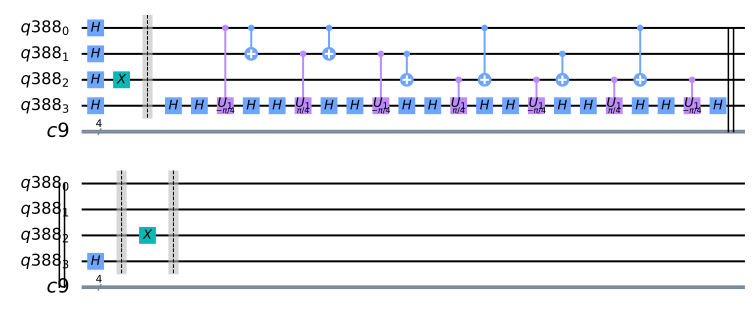

In [38]:
# Uncomment the oracle that you require

#oracle_10()
#oracle_110()
oracle_1011()
#oracle_11001()
qc.draw(output="mpl",scale=0.4)

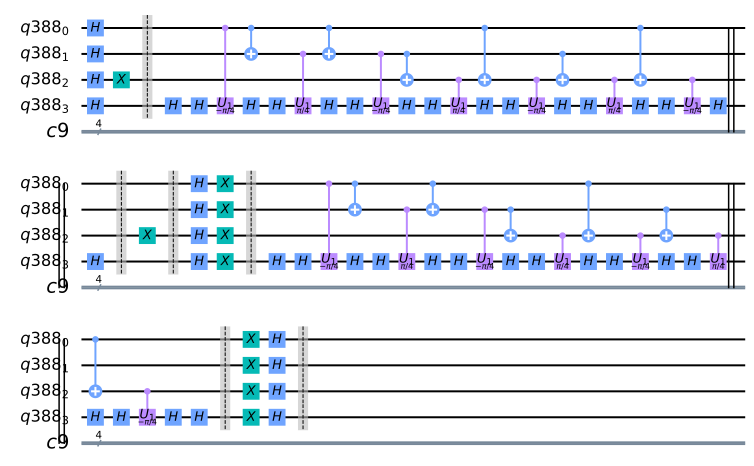

In [39]:
# Uncomment the amplification that you require
# The numbers refer to the number of qubits

#amplify_2()
#amplify_3()
amplify_4()
#amplify_5()

qc.draw(output="mpl",scale=0.4)

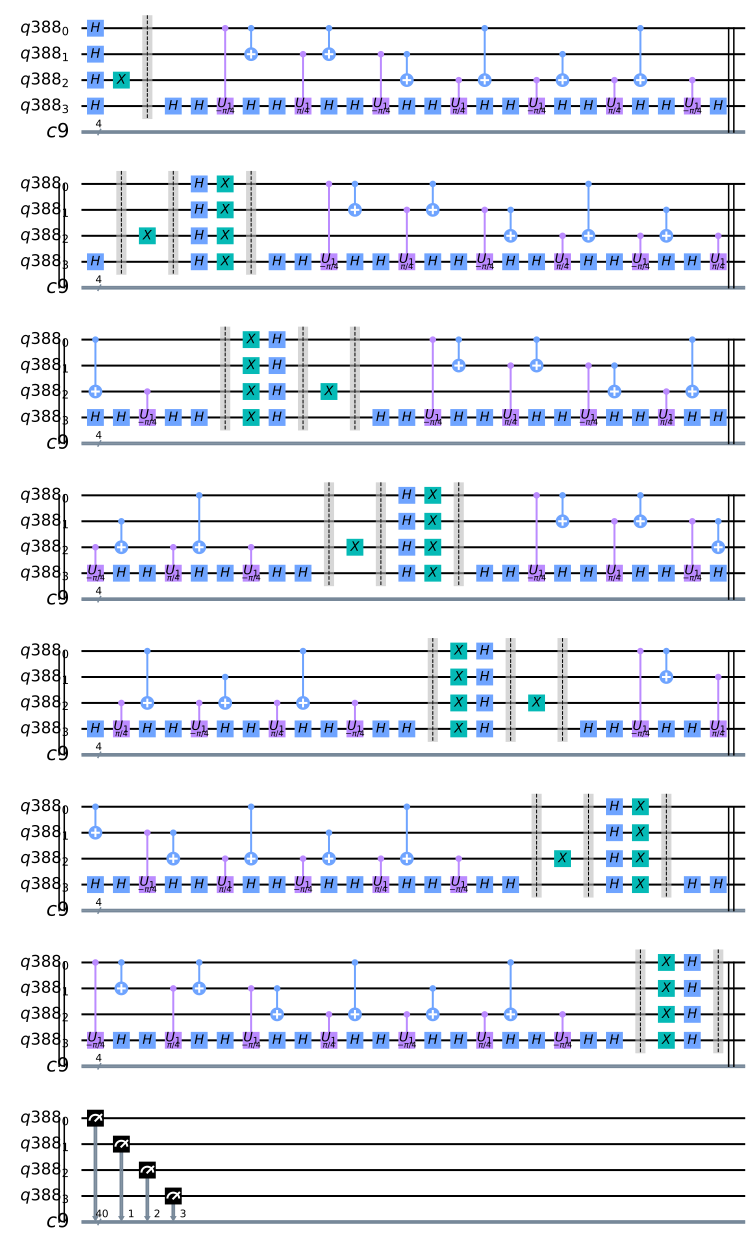

In [40]:
# Complete the circuit

for i in range(grover_iteration-1):   #1 iteration already completed above
  select_circuit()

qc.measure(qr, cr)
qc.draw(output="mpl",scale=0.4)

[ 0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j  0.+0.00000000e+00j -1.+8.87231608e-15j
  0.+0.00000000e+00j  0.+0.00000000e+00j  0.+0.00000000e+00j
  0.+0.00000000e+00j]


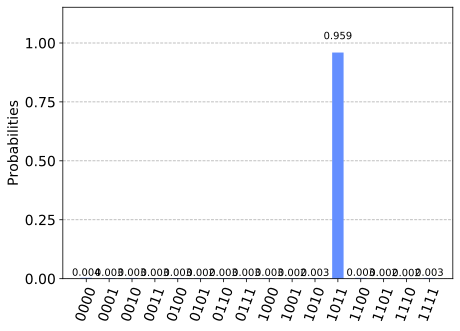

In [41]:
# Run against simulator

# Check the state vector
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(qc, backend_sim)
statevec = job_sim.result().get_statevector()
print(statevec)

backend = BasicAer.get_backend('qasm_simulator')
shots = 8192
timeBefore_sim = time.clock()
results = execute(qc, backend=backend, shots=shots).result()
timeAfter_sim = time.clock()
answer = results.get_counts()
plot_histogram(answer)


In [42]:
# Get measurements

#Manual Timing
elapsed_time_sim = timeAfter_sim - timeBefore_sim
#print(elapsed_time_sim)
  
#Percentage Value for target
target_percent = answer[target]/sum(answer.values())
print('Target Probability:', target_percent)

#Manual Timing
elapsed_time_sim = timeAfter_sim - timeBefore_sim
print('Time Taken:',elapsed_time_sim )

sim_backend = backend
sim_target_percent = target_percent
sim_time_taken = results.time_taken
print('Internal Process:', sim_time_taken)

Target Probability: 0.95947265625
Time Taken: 0.3715938000004826
Internal Process: 0.07385563850402832


# <font color=red> **Important Information for running on the IBM machines** </font>
### In order to keep personal / secure information separate from the Python program, rather than hard-code the quantum server key directly into the Python code, it is stored in the local file called *ibm_token.txt* supplied with this notebook. This file should be placed in the same directory as the notebook and the code will run against the quantum server.
### <font color=red> **My IBM key is in the file supplied with this notebook - make sure that this is in place before running** </font>

In [43]:
# Run on quantum machine

from qiskit import IBMQ

  # Get login token for machines
f = open('ibm_token.txt')

ibm_key = f.readline()
f.close()
IBMQ.save_account(ibm_key )

IBMQ.load_account()
IBMQ.providers()

provider = IBMQ.get_provider("ibm-q")



Credentials already present. Set overwrite=True to overwrite.
Credentials are already in use. The existing account in the session will be replaced.


In [44]:
# Documentation code showing the available servers and state

for backend in provider.backends():
    try:
        qubit_count = len(backend.properties().qubits)
    except:
        qubit_count = "simulated"
        
    print(f"{backend.name()} has {backend.status().pending_jobs} queued and {qubit_count} qubits")

ibmq_qasm_simulator has 2 queued and simulated qubits
ibmqx2 has 3 queued and 5 qubits
ibmq_16_melbourne has 5 queued and 15 qubits
ibmq_vigo has 119 queued and 5 qubits
ibmq_ourense has 18 queued and 5 qubits
ibmq_london has 13 queued and 5 qubits
ibmq_burlington has 4 queued and 5 qubits
ibmq_essex has 17 queued and 5 qubits
ibmq_armonk has 2 queued and 1 qubits


Job Status: job has successfully run


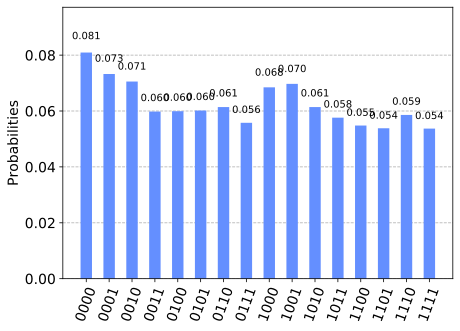

In [45]:
selected_ibm_server = "ibmq_london"
shots =8192
#backend = provider.get_backend("ibmq_london")
backend = provider.get_backend(selected_ibm_server)

optimization = 3

from qiskit.tools.monitor import job_monitor
timeBefore_aer = time.clock()

job = execute(qc, backend=backend, shots=8192, max_credits=10,optimization_level=optimization)
timeAfter_aer = time.clock()

job_monitor(job, interval = 2)

results = job.result()
answer = results.get_counts(qc)
plot_histogram(answer)



In [46]:
#Manual Timing
elapsed_time_aer = timeAfter_aer - timeBefore_aer

#Percentage Value for target
target_percent = answer[target]/sum(answer.values())

internal_time = results.time_taken

print('Target Probability:', target_percent)
print('Time Taken:',elapsed_time_aer )
print('Internal Process:',internal_time)

Target Probability: 0.0576171875
Time Taken: 7.476178700000673
Internal Process: 45.631107568740845


In [47]:
for backend in Aer.backends():
    print(backend)

qasm_simulator
statevector_simulator
unitary_simulator
pulse_simulator
